In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import random

In [2]:
data = pd.read_csv('kc3_csv.csv')
if 'id' in data.columns:
    data.drop('id', axis=1, inplace=True)
X = data.drop('Defective', axis=1)
y = data['Defective'].map({'N': 0, 'Y': 1})

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dim = X_train.shape[1]

In [4]:
# Lyrebird Optimizer
def lyrebirdoptimizer(fitnessfunc, dim, popsize=30, maxiter=200):
    pop = np.random.randint(0, 2, (popsize, dim))
    fitness = np.zeros(popsize)
    for i in range(popsize):
        fitness[i] = fitnessfunc(pop[i])
    bestidx = np.argmin(fitness)
    bestsolution = pop[bestidx].copy()
    bestfitness = fitness[bestidx]

    convergence_curve = [bestfitness]

    for it in range(maxiter):
        for i in range(popsize):
            if np.random.rand() < 0.5:
                candidate = (pop[i] + np.random.randint(0, 2, dim)) % 2
            else:
                candidate = pop[i].copy()
                flip_idx = np.random.choice(dim, size=dim // 4 + 1, replace=False)
                candidate[flip_idx] = 1 - candidate[flip_idx]
            candfitness = fitnessfunc(candidate)
            if candfitness < fitness[i]:
                pop[i] = candidate
                fitness[i] = candfitness
                if candfitness < bestfitness:
                    bestsolution = candidate.copy()
                    bestfitness = candfitness
        convergence_curve.append(bestfitness)
    return bestsolution, bestfitness, convergence_curve

In [5]:
# Fitness function using SVM (probability=True for ROC)
def fsfitness(individual):
    idx = np.where(individual == 1)[0]
    if len(idx) == 0:
        return 1.0
    clf = SVC(probability=True, random_state=42)
    try:
        clf.fit(X_train.iloc[:, idx], y_train)
        preds = clf.predict(X_test.iloc[:, idx])
        acc = np.mean(preds == y_test)
        return 1 - acc
    except:
        return 1.0

In [6]:
# Run Lyrebird Optimization
bestbinmask, bestval, convergencecurve = lyrebirdoptimizer(fsfitness, dim, popsize=30, maxiter=200)
selected_indices = np.where(bestbinmask == 1)[0]
print(f"Selected feature indices by LOA: {selected_indices}")

Selected feature indices by LOA: [ 0  1  3  4  5  7  9 14 15 16 17 19 20 21 23 30 31 32 34 36 38]


In [7]:
# Performance WITHOUT feature selection (with SVM)
clf_all = SVC(probability=True, random_state=42)
clf_all.fit(X_train, y_train)
preds_all = clf_all.predict(X_test)
probs_all = clf_all.predict_proba(X_test)[:, 1]
acc_all = accuracy_score(y_test, preds_all)
prec_all = precision_score(y_test, preds_all, zero_division=0)
rec_all = recall_score(y_test, preds_all)
f1_all = f1_score(y_test, preds_all)

print("\nPerformance WITHOUT Feature Selection:")
print(f"Accuracy: {acc_all:.4f}, Precision: {prec_all:.4f}, Recall: {rec_all:.4f}, F1-score: {f1_all:.4f}")


Performance WITHOUT Feature Selection:
Accuracy: 0.7692, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


In [8]:
# Performance WITH feature selection
if len(selected_indices) > 0:
    clf_fs = SVC(probability=True, random_state=42)
    clf_fs.fit(X_train.iloc[:, selected_indices], y_train)
    preds_fs = clf_fs.predict(X_test.iloc[:, selected_indices])
    probs_fs = clf_fs.predict_proba(X_test.iloc[:, selected_indices])[:, 1]
    acc_fs = accuracy_score(y_test, preds_fs)
    prec_fs = precision_score(y_test, preds_fs, zero_division=0)
    rec_fs = recall_score(y_test, preds_fs)
    f1_fs = f1_score(y_test, preds_fs)

    print("\nPerformance WITH Lyrebird Feature Selection:")
    print(f"Accuracy: {acc_fs:.4f}, Precision: {prec_fs:.4f}, Recall: {rec_fs:.4f}, F1-score: {f1_fs:.4f}")
else:
    print("No features selected by LOA!")


Performance WITH Lyrebird Feature Selection:
Accuracy: 0.7949, Precision: 1.0000, Recall: 0.1111, F1-score: 0.2000


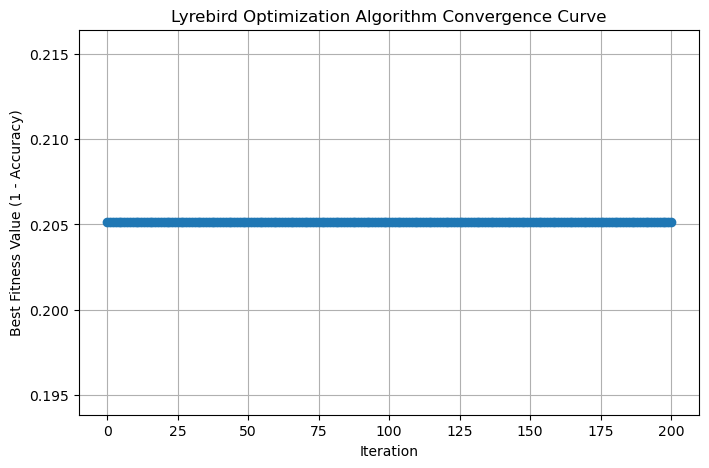

In [9]:
# Plot convergence curve
plt.figure(figsize=(8, 5))
plt.plot(convergencecurve, marker='o', linestyle='-')
plt.title('Lyrebird Optimization Algorithm Convergence Curve')
plt.xlabel('Iteration')
plt.ylabel('Best Fitness Value (1 - Accuracy)')
plt.grid(True)
plt.show()

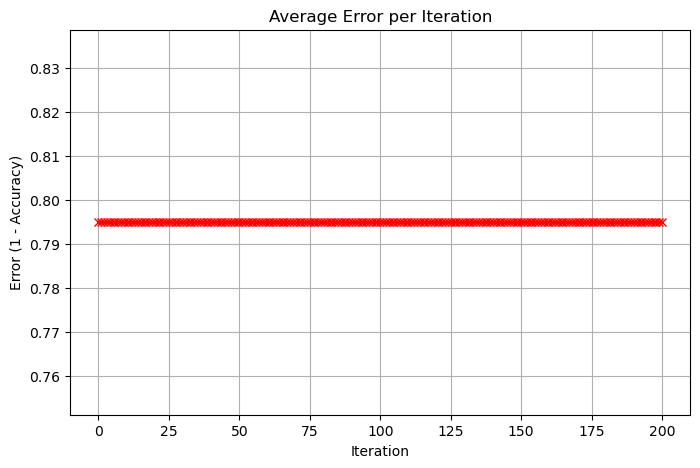

In [10]:

# Average error per iteration
avg_error = [1 - val for val in convergencecurve]
plt.figure(figsize=(8, 5))
plt.plot(avg_error, marker='x', color='red', linestyle='--')
plt.title('Average Error per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Error (1 - Accuracy)')
plt.grid(True)
plt.show()

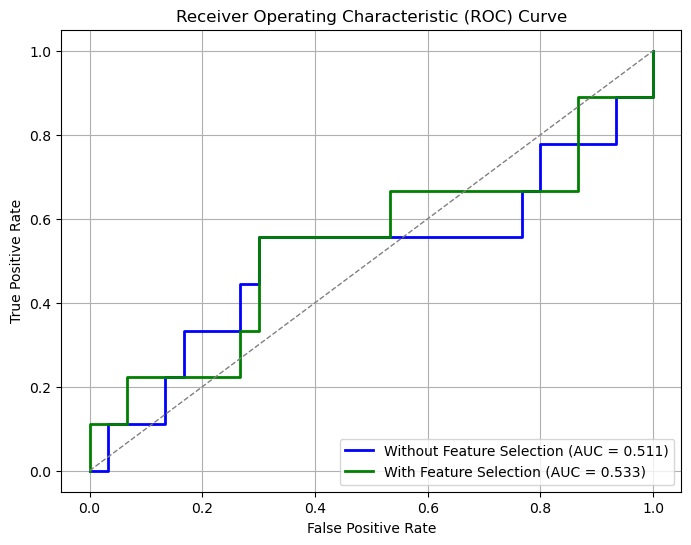

In [11]:
# ROC curve
plt.figure(figsize=(8, 6))
fpr_all, tpr_all, _ = roc_curve(y_test, probs_all)
roc_auc_all = auc(fpr_all, tpr_all)
plt.plot(fpr_all, tpr_all, color='blue', lw=2, label=f'Without Feature Selection (AUC = {roc_auc_all:.3f})')

if len(selected_indices) > 0:
    fpr_fs, tpr_fs, _ = roc_curve(y_test, probs_fs)
    roc_auc_fs = auc(fpr_fs, tpr_fs)
    plt.plot(fpr_fs, tpr_fs, color='green', lw=2, label=f'With Feature Selection (AUC = {roc_auc_fs:.3f})')

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()